In [27]:
from collections import Counter
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import fa2

from datautils import datautils
from community import community_louvain
from datautils import stats

In [3]:
GRAPH_PATH = 'graph/universe_epis_1.pickle'
GRAPH_PATH_EPISODES = 'graph/universe_episodes.pickle'

In [4]:
loader = datautils.Loader()
loader.load("data/characters/")
data = loader.to_dataframe()
loader.drop()
data.head()

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died
0,%22Blue%22_Imcrix,"""Blue"" Imcrix","""Blue"" Imcrix was an infamous male Taloron cri...","[Star_Wars_Legends, Taloron, Gender/Legends, C...",Taloron,Male,NaN,NaN,NaN
1,%22Fugitive%22_Fod,"""Fugitive"" Fod","""Fugitive"" Fod was a male Yuzzum from Endor wh...","[Star_Wars_Legends, Endor/Legends, Yuzzum/Lege...",Yuzzum,Male,NaN,Endor,NaN
2,%22Shady%22_Pers,"""Shady"" Pers","""Shady"" Pers was a male Human smuggler living ...","[Star_Wars_Legends, Kashyyyk/Legends, Human/Le...",Human,Male,[Myyydril],Kashyyyk,NaN
3,%27Ndranth_Poussan,'Ndranth Poussan,'Ndranth Poussan was a Human male starfighter ...,"[Star_Wars_Legends, Wookieepedia:Good_articles...",Human,Male,"[Agamar Resistance, Alliance to Restore the Re...",Agamar,"[1 BBY, near Brigia]"
4,0761,0761,0761 was a stormtrooper who was stationed on C...,"[Star_Wars_Legends, 5_ABY/Legends, Ciutric_IV,...",Human,Male,"[Galactic EmpireStormtrooper Corps, Stormtroop...",NaN,"[5 ABY, Ciutric IV]"


In [10]:
episodes = [
    "Star_Wars:_Episode_I_The_Phantom_Menace",
    "Star_Wars:_Episode_II_Attack_of_the_Clones",
    "Star_Wars:_Episode_III_Revenge_of_the_Sith",
    "Star_Wars:_Episode_IV_A_New_Hope",
    "Star_Wars:_Episode_V_The_Empire_Strikes_Back",
    "Star_Wars:_Episode_VI_Return_of_the_Jedi",
    "Star_Wars:_Episode_VII_The_Force_Awakens",
    "Star_Wars:_Episode_VIII_The_Last_Jedi",
    "Star_Wars:_Episode_IX_The_Rise_of_Skywalker",
]

characters_in_episodes = []

for _, char in data.iterrows():
    # iterate over records
    for crosslink in char.Crosslinks:
        if crosslink in episodes:
            # append only characters which have crosslink to one of the episodes
            characters_in_episodes.append(char.Name)
            break

In [11]:
len(characters_in_episodes)

3392

In [12]:
episodes_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
episodes_characters_data.head()

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died
5,1047,1047,1047 was a Human male stormtrooper who served ...,"[Star_Wars_Legends, Wookieepedia:Good_articles...",Human,Male,"[Galactic Empire, Zeta Squadron, Zeta Squadron]",NaN,NaN
7,1138_(First_Order),1138 (First Order),1138 was a human male stormtrooper who served ...,"[Canon, 1138, Special:Upload, Human, Gender, F...",Human,Male,"[First Order, Stormtrooper Corps, Stormtrooper...",NaN,NaN
28,4/163,4/163,CT-4/163 was a clone trooper in the Grand Army...,"[Star_Wars_Legends, Kamino/Legends, Human/Lege...",Human,Male,"[Galactic Republic, Grand Army of the Republic...",Kamino,NaN
30,5/373,5/373,5/373 was a clone trooper in the Grand Army of...,"[Star_Wars_Legends, Wookieepedia:Sourcing, Spe...",Human,Male,"[Galactic RepublicGrand Army of the Republic, ...",Kamino,NaN
32,6/298,6/298,6/298 was a clone trooper in the Grand Army of...,"[Star_Wars_Legends, Kamino/Legends, 32_BBY/Leg...",Human,Male,"[Galactic Republic, Grand Army of the Republic...",Kamino,NaN


In [13]:
# Aleks: Use graph.create_directed_graph once ready

if os.path.exists(GRAPH_PATH_EPISODES):
    with open(GRAPH_PATH_EPISODES, 'rb') as f:
        Universe_episodes = pickle.load(f)
else:
    # initialize universe directional graph
    Universe_episodes = nx.DiGraph()
    for _, character in episodes_characters_data.iterrows():
        # add node with metadata for each character
        Universe_episodes.add_node(character.Name)
        for connection in character.Crosslinks:
            if connection in episodes_characters_data.Name.values:
                # add edge between character and its connection if it's not a self loop
                if connection != character.Name:
                    Universe_episodes.add_edge(character.Name, connection)

    with open(GRAPH_PATH, 'wb') as f:
        pickle.dump(Universe_episodes, f)

In [19]:
print(f"Number of nodes: {len(Universe_episodes.nodes)}")
print(f"Number of links: {len(Universe_episodes.edges)}")
print(stats.calc_stats(Universe_episodes.degree()))

Number of nodes: 3392
Number of links: 15621
{'mean': 9.210495283018869, 'median': 4.0, 'mode': 0, 'min': 0, 'max': 640}


In [21]:
# Aleks: Use graph.conencted_components once ready

largest_component_episodes = sorted(nx.weakly_connected_components(Universe_episodes), key=len, reverse=True)[0]
Undirected_universe_lc_episodes = Universe_episodes.subgraph(largest_component_episodes).to_undirected()

In [22]:
# use Force Atlas 2

FA_POSITIONS = "data/positions_episodes.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc_episodes, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

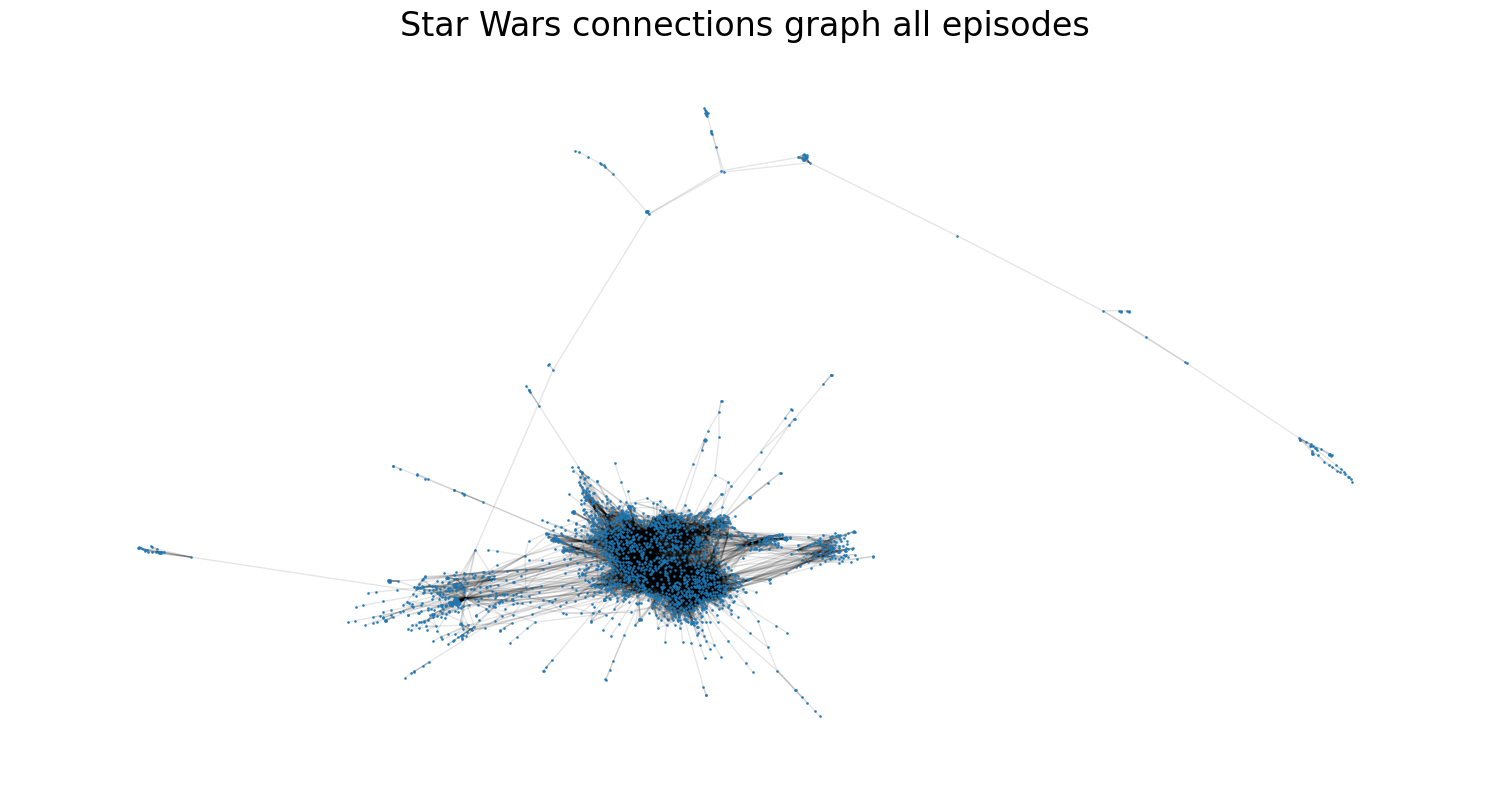

In [23]:
# Aleks: Use graph.plot_graph_with_positions once ready

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc_episodes, positions, node_size=0.9, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc_episodes, positions, alpha=0.1, ax=ax)
ax.set_title("Star Wars connections graph all episodes", size=24)
ax.axis("off")
# plt.show()
plt.tight_layout()
#plt.savefig('starwars_network.png')

### Comunities

In [24]:
universe = Universe_episodes.to_undirected()

In [25]:
# Aleks: Use graph.connected_components once ready

episodes_subgraph = universe.subgraph(node for node in universe.nodes() if universe.degree(node) > 0)
episodes_subgraph = episodes_subgraph.subgraph(sorted(nx.connected_components(episodes_subgraph), key=len, reverse=True)[0])
degrees = [deg for _, deg in episodes_subgraph.degree()]

In [40]:
# compute the best partition 
partition = community_louvain.best_partition(episodes_subgraph)

In [41]:
# compute graph positions
POSITIONS_COMMUNITIES = "data/positions_communities.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(POSITIONS_COMMUNITIES ):
    with open(POSITIONS_COMMUNITIES , "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions_communities = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(episodes_subgraph, pos=None, iterations=2000)
    # save to pickle for later use
    with open(POSITIONS_COMMUNITIES, "wb") as wbfile:
        pickle.dump(positions_communities, wbfile)

In [42]:
# modularity 
mod = community_louvain.modularity(partition, episodes_subgraph, weight='weight')
mod

0.5679345684135461

In [43]:
node_size = [episodes_subgraph.degree(node) for node in episodes_subgraph.nodes]

In [44]:
# number of communities
count = Counter(partition.values())
print(count)

Counter({22: 453, 3: 347, 7: 335, 1: 300, 13: 179, 8: 156, 10: 112, 20: 60, 11: 55, 9: 50, 14: 46, 12: 39, 5: 31, 18: 28, 4: 22, 19: 18, 2: 12, 0: 10, 6: 6, 16: 5, 21: 5, 15: 4, 17: 3})


<BarContainer object of 23 artists>

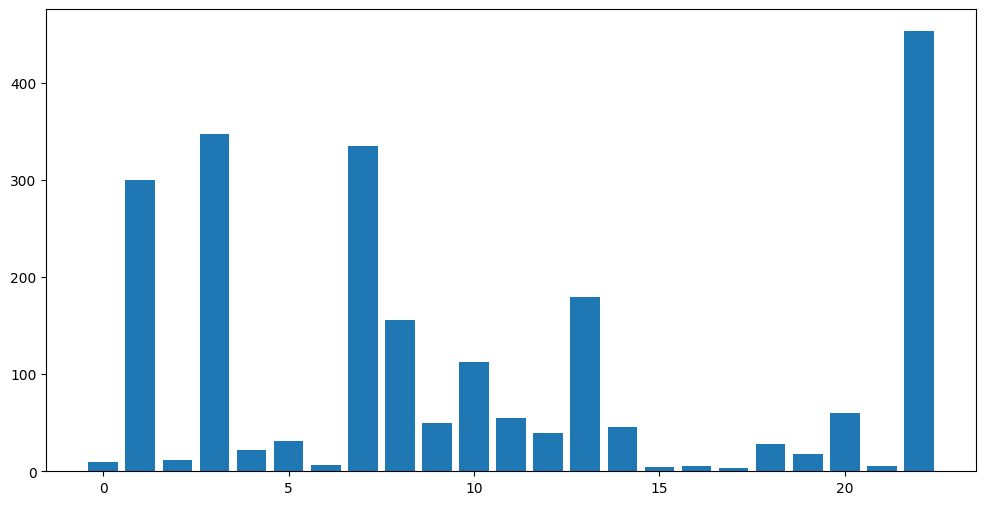

In [45]:
plt.figure(figsize = (12,6))
plt.bar(count.keys(), count.values())

In [46]:
node_degrees = sorted(episodes_subgraph.degree, key=lambda x: x[1], reverse=True)
labels = [(name[0], data[data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:10]]

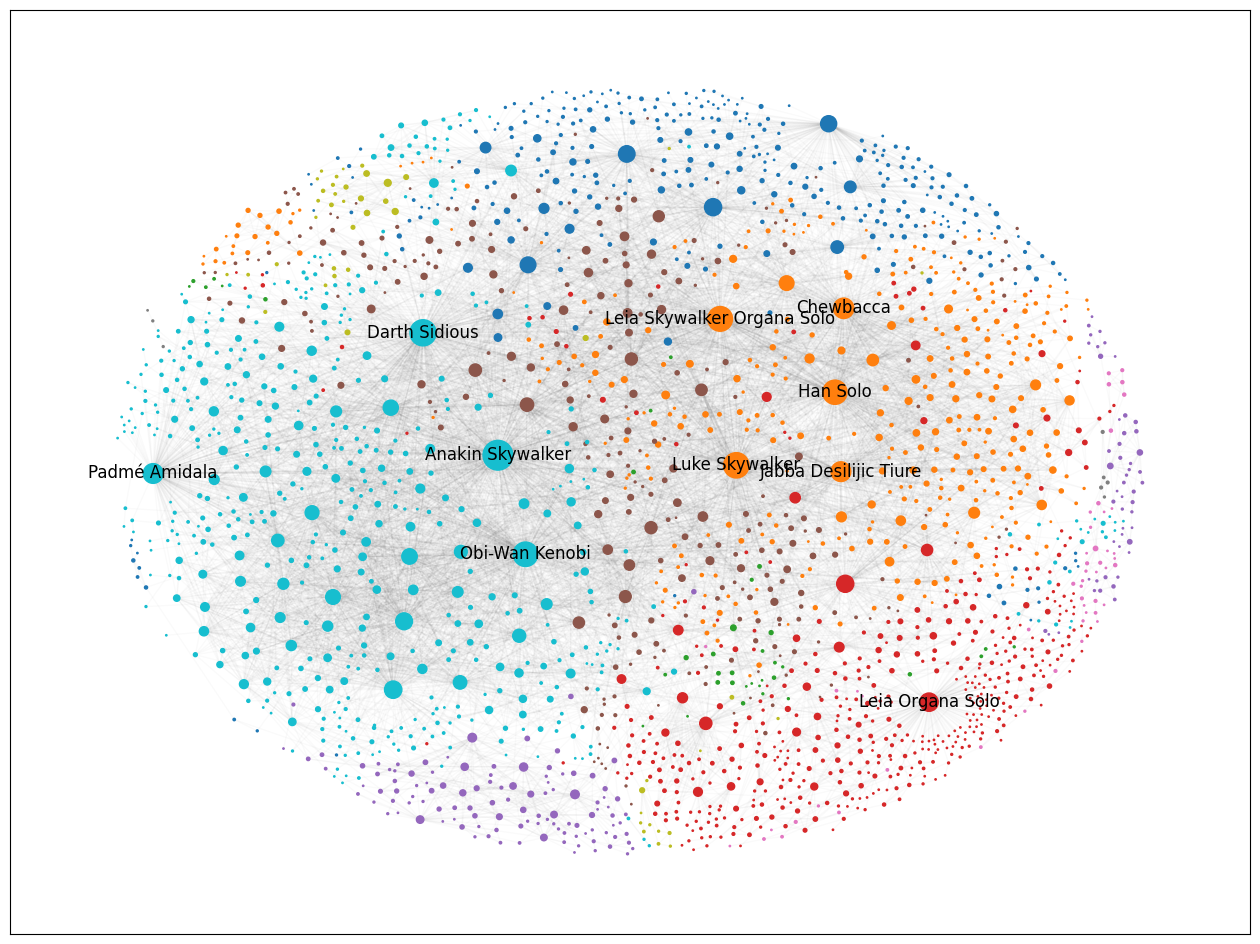

In [47]:
# Aleks: Use graph.plot_graph_with_positions once ready

plt.figure(figsize=(16, 12))
cmap = cm.get_cmap("tab10", max(partition.values()) + 1)
nx.draw_networkx_nodes(
    episodes_subgraph, positions, node_size=node_size,
    cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(episodes_subgraph, positions, alpha=0.02)
nx.draw_networkx_labels(episodes_subgraph, positions, labels=dict(labels), font_color="black")
plt.show()

### Division into individual movies

In [ ]:
# Aleks: try to reuse as much code as possible from previous section. You're doing exactly the same operations
# Just for the different data

In [6]:
episodes = [
    "Star_Wars:_Episode_I_The_Phantom_Menace",
    "Star_Wars:_Episode_II_Attack_of_the_Clones",
    "Star_Wars:_Episode_III_Revenge_of_the_Sith",
    "Star_Wars:_Episode_IV_A_New_Hope",
    "Star_Wars:_Episode_V_The_Empire_Strikes_Back",
    "Star_Wars:_Episode_VI_Return_of_the_Jedi",
    "Star_Wars:_Episode_VII_The_Force_Awakens",
    "Star_Wars:_Episode_VIII_The_Last_Jedi",
    "Star_Wars:_Episode_IX_The_Rise_of_Skywalker",
]


In [7]:
episodes[0]

'Star_Wars:_Episode_I_The_Phantom_Menace'

In [8]:
characters_in_episodes = datautils.find_rows_with(episodes[0], data, lookup_column="Crosslinks", match_column="Name")
episode_1_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_1_characters_data)

366

In [11]:
if os.path.exists(GRAPH_PATH):
    with open(GRAPH_PATH, 'rb') as f:
        Universe_epis_1 = pickle.load(f)
else:
    # initialize universe directional graph
    Universe_epis_1 = nx.DiGraph()
    for _, character in episode_1_characters_data.iterrows():
        # add node with metadata for each character
        Universe_epis_1.add_node(character.Name)
        for connection in character.Crosslinks:
            if connection in episode_1_characters_data.Name.values:
                # add edge between character and its connection if it's not a self loop
                if connection != character.Name:
                    Universe_epis_1.add_edge(character.Name, connection)

    with open(GRAPH_PATH, 'wb') as f:
        pickle.dump(Universe_epis_1, f)

In [12]:
print(f"Number of nodes: {len(Universe_epis_1.nodes)}")
print(f"Number of links: {len(Universe_epis_1.edges)}")

Number of nodes: 366
Number of links: 1953


In [ ]:
largest_component_epis_1 = sorted(nx.weakly_connected_components(Universe_epis_1), key=len, reverse=True)[0]
Undirected_universe_lc_epis_1 = Universe_epis_1.subgraph(largest_component_epis_1).to_undirected()

largest_component_epis_1

In [15]:
# use Force Atlas 2

FA_POSITIONS = "data/positions_epis_1.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc_epis_1, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

100%|██████████| 2000/2000 [00:01<00:00, 1559.19it/s]

BarnesHut Approximation  took  0.36  seconds
Repulsion forces  took  0.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


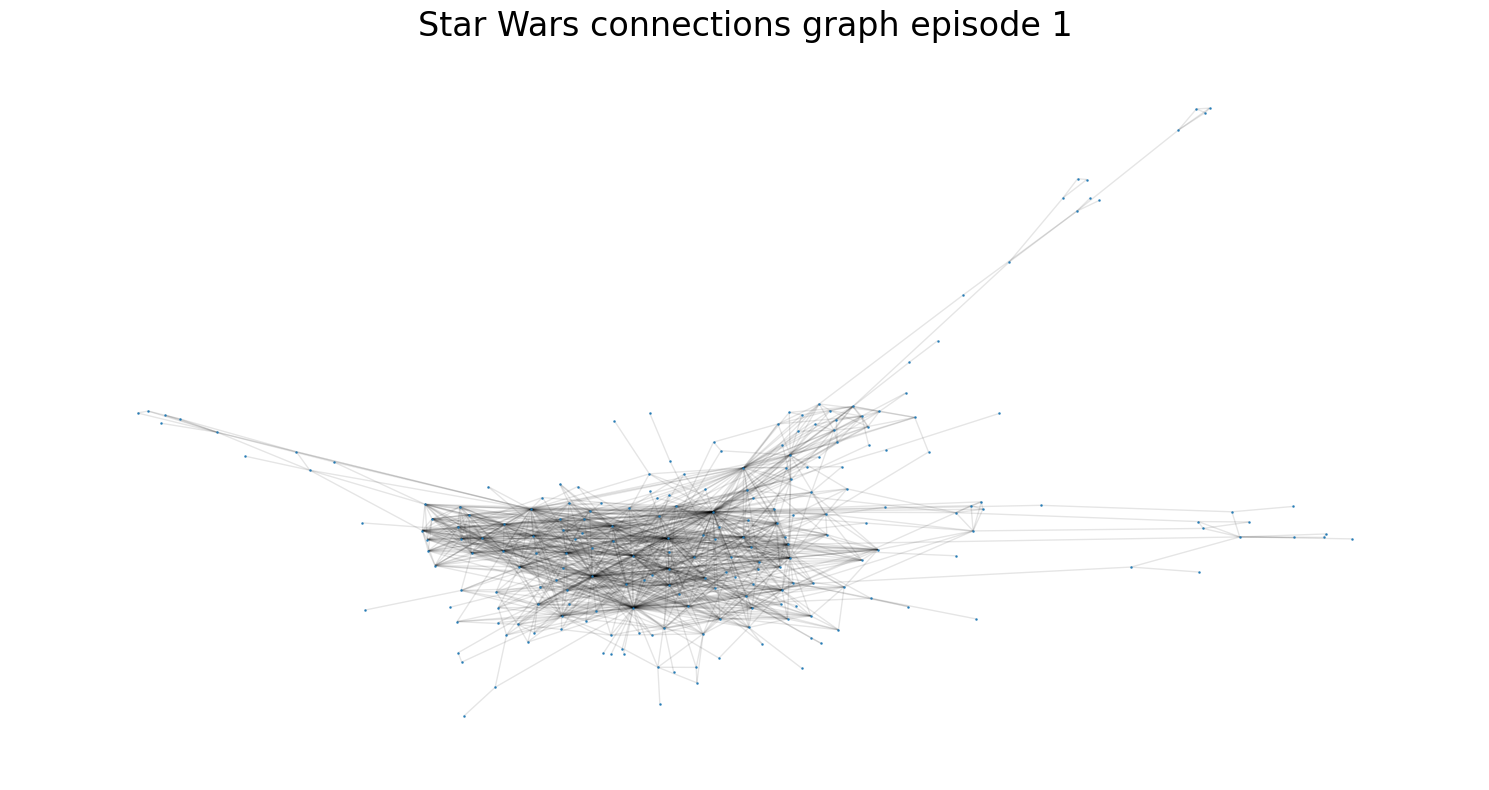

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc_epis_1, positions, node_size=0.7, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc_epis_1, positions, alpha=0.1, ax=ax)
ax.set_title("Star Wars connections graph episode 1", size=24)
ax.axis("off")
# plt.show()
plt.tight_layout()
#plt.savefig('starwars_network.png')

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[1], data, lookup_column="Crosslinks", match_column="Name")
episode_2_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_2_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[2], data, lookup_column="Crosslinks", match_column="Name")
episode_3_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_3_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[3], data, lookup_column="Crosslinks", match_column="Name")
episode_4_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_4_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[4], data, lookup_column="Crosslinks", match_column="Name")
episode_5_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_5_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[5], data, lookup_column="Crosslinks", match_column="Name")
episode_6_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_6_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[6], data, lookup_column="Crosslinks", match_column="Name")
episode_7_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_7_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[7], data, lookup_column="Crosslinks", match_column="Name")
episode_8_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_8_characters_data)

In [ ]:
characters_in_episodes = datautils.find_rows_with(episodes[8], data, lookup_column="Crosslinks", match_column="Name")
episode_9_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
len(episode_9_characters_data)